In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
from datetime import date
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [1]:
def graphRes(act, pred):
    ax = plt.gca()
    for pos in positions:
        ax.scatter(act[pos],pred[pos], label=f'{pos} ({r2_score(act[pos], pred[pos]).round(2)})')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(labels)
    ax.plot(act['QB'],act['QB'],color='black') # y==x reference line
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

def printStats(y_dev, y_pred):
    graphRes(y_dev, y_pred)

    stats = pd.DataFrame(index = ['MAE','RMSE','R^2'], columns = [positions])
    for pos in positions:
        stats.loc['MAE',pos] = mean_absolute_error(y_dev[pos], y_pred[pos]).round(1)
        stats.loc['RMSE',pos] = round(math.sqrt(mean_squared_error(y_dev[pos], y_pred[pos])),1)
        stats.loc['R^2',pos] = r2_score(y_dev[pos], y_pred[pos]).round(2)
    
    display(stats)
    
def cvGrid(params):
    names = ['param_' + x for x in list(params.keys())]
    return pd.DataFrame(grid.cv_results_)[names+['mean_test_score','std_test_score','rank_test_score','mean_fit_time','mean_score_time','std_fit_time','std_score_time']].sort_values(names)


In [90]:
# Partition training, dev, and test data
positions = ['QB','RB','WR','TE']
X_train, X_dev, X_test = {}, {}, {}
y_train, y_dev, y_test = {}, {}, {}
data = {}
for pos in positions:
    Xy = pd.read_csv(f'../{pos}.csv').dropna(subset=['fanPts'])
    data[pos] = Xy
    X = Xy.loc[:,Xy.columns.str.contains('-\d+') | Xy.columns.str.match('fanPts')] \
        .drop('fanPts',axis=1) \
        .fillna(0)
    y = Xy.fanPts
    
    # Split
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.3, random_state=0)
    X_dev_raw, X_test_raw, y_dev_raw, y_test_raw = train_test_split(X_test_raw, y_test_raw, test_size=0.5, random_state=0)
    
    # Scale X data
    ss = preprocessing.StandardScaler()
    X_train[pos] = pd.DataFrame(ss.fit_transform(X_train_raw), columns=X_train_raw.columns)
    X_dev[pos] = pd.DataFrame(ss.fit_transform(X_dev_raw), columns=X_dev_raw.columns)
    X_test[pos] = pd.DataFrame(ss.fit_transform(X_test_raw), columns=X_test_raw.columns)
    
    # Leave y data in original units
    y_train[pos] = y_train_raw
    y_dev[pos] = y_dev_raw
    y_test[pos] = y_test_raw

# PCA
pca = {}
pc = {}
X_train_pc = {}
X_dev_pc = {}
X_test_pc = {}
for pos in positions:
    pca[pos] = PCA(n_components='mle')
    pc[pos] = pca[pos].fit(X_train[pos])
    plt.plot(np.cumsum(pca[pos].explained_variance_ratio_))
    plt.plot(pca[pos].explained_variance_ratio_)
plt.show()

for pos in positions:
    X_train[pos] = pca[pos].transform(X_train[pos])
    X_dev[pos] = pca[pos].transform(X_dev[pos])
    X_test[pos] = pca[pos].transform(X_test[pos])
    plt.scatter(X_train[pos][:,0],X_train[pos][:,1],c=y_train[pos])
plt.colorbar()
plt.show()

### K Neighbors Regression

#### Base model

,QB,RB,WR,TE
MAE,65.000,44.800,38.800,23.300
RMSE,84.800,68.400,60.500,32.300
R^2,0.390,0.300,0.310,0.400


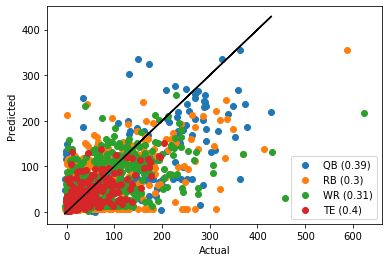

In [95]:
y_pred = {}
for pos in positions:
    m = neighbors.KNeighborsRegressor()
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
printStats(y_dev, y_pred)

#### GridSearchCV

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 992 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1408 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 1888 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 1985 out of 2000 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 1888 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   31.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.7min finished


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 1888 tasks      | elapsed:   21.0s


QB: {'metric': 'euclidean', 'n_neighbors': 41, 'weights': 'distance'}
RB: {'metric': 'euclidean', 'n_neighbors': 23, 'weights': 'distance'}
WR: {'metric': 'euclidean', 'n_neighbors': 29, 'weights': 'distance'}
TE: {'metric': 'euclidean', 'n_neighbors': 18, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   22.3s finished


,QB,RB,WR,TE
MAE,63.400,44.100,38.200,22.700
RMSE,82.100,64.900,57.200,32.100
R^2,0.430,0.370,0.380,0.410


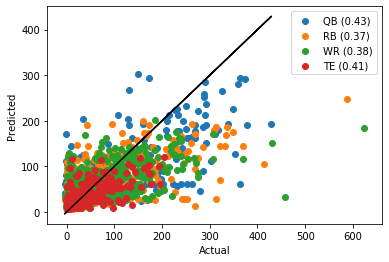

In [96]:
y_pred = {}
bestParams = {}
for pos in positions:
    params = {
        'weights':['distance','uniform'],
        'metric':['manhattan','euclidean'],
        'n_neighbors':[x for x in range(1,101)],
    }

    grid = GridSearchCV(
        neighbors.KNeighborsRegressor(),
        params,
        n_jobs = -1,
        verbose = 7,
        cv = 5
    ).fit(X_train[pos],y_train[pos])

    bestParams[pos] = grid.best_params_

    m = neighbors.KNeighborsRegressor(**grid.best_params_)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])

    #cvGrid(params)
    
for pos in positions:
    print(f'{pos}: {bestParams[pos]}')
printStats(y_dev,y_pred)